# Recherche tabu

In [2]:
# math framework
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# other Framework
from collections import deque
import random
from functools import lru_cache
from IPython.display import display, clear_output
from dataclasses import dataclass
from ipywidgets import IntProgress
import time
import copy
from joblib import Parallel, delayed
import psutil

# our own functions
from functions import get_vrptw_instance, show_routes

## Variables

In [3]:
# Instances
instance_name = 'C101.txt'
data_set, data_set_best_solution = get_vrptw_instance(instance_name)

# DataSET
coords = data_set['node_coord']
nb_client = len(coords) - 1

# dataSetSolution
instance_best_solution = data_set_best_solution['routes']

print(type(data_set['time_window']))
print(type(data_set['service_time']))


# Distance between two points
vertex = np.array(coords)

distance = distance_matrix(vertex, vertex)

ALPHA = 100
BETA = 30
# container of important and reusable vrp data
@dataclass
class VRPInstance:
    """
    Represents a Vehicle Routing Problem (VRP) or VRP with Time Windows (VRPTW) instance.

    Attributes:
        data_set (dict): Raw dataset loaded from a VRP instance file (e.g., from vrplib).
        nb_client (int): Number of clients (excluding the depot).
        capacity (int): Vehicle capacity limit.
        demand (List[int]): Demand value for each client.
        time_window (np.ndarray): Time windows for each client, e.g., [[a1, b1], [a2, b2], ...].
        service_time (np.ndarray): Service time required at each client.
        distance (np.ndarray): Full distance matrix between all nodes (depot + clients).
    candidate_list (dict): Dictionary mapping each client to its K nearest neighbors.
    """
    data_set: dict
    nb_client: int
    capacity: int
    demand: list[int]
    time_window: np.ndarray
    service_time: np.ndarray
    distance: np.ndarray
    candidate_list: dict = None


# Initialization
instance = VRPInstance(
    data_set=data_set,
    nb_client=nb_client,
    capacity=data_set['capacity'],
    demand=data_set['demand'],
    time_window=data_set['time_window'],
    service_time=data_set['service_time'],
    distance=distance,
)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
def candidate_list(instance, K=15):
    """
    Build a candidate list for each client (K nearest neighbors).
    
    Args:
        instance: VRPInstance object
        K: Number of nearest neighbors
    
    Returns:
        dict: {client: [list of K nearest neighbors]}
    """
    candidates = {}
    
    for client in range(1, instance.nb_client + 1):
        distances = []
        for other in range(1, instance.nb_client + 1):
            if other != client:
                distances.append((other, instance.distance[client, other]))
        
        distances.sort(key=lambda x: x[1])
        candidates[client] = [neighbor for neighbor, _ in distances[:K]]
    
    return candidates

instance.candidate_list = candidate_list(instance, K=15)

In [5]:
def merge(solution):
    """
    Merge a solution into a giant list
    Args:
        solution(list[list[int]]):
            A solution of the vrp.
            With k lists of c int elements.
            With k number of routes(trucks) and c number of client in the route.
    Returns:
        giant_tour(list[int]): Merge of the all routes into a giant list.
    """
    giant_tour = []
    for route in solution:
        for city in route:
            if city != 0:
                giant_tour.append(city)
    return giant_tour



In [6]:
"""def split(giant_tour, instance: VRPInstance):
    
    Split the giant tour into multiple feasible routes.
    Args:
        giant_tour (list[int]): A giant tour representing a full permutation
        of all clients.

    Returns:
        sol (list[list[int]]): A list of routes, where each route is a list
        of clients assigned to the same truck, respecting capacity constraints.
    
    route=[]
    sol =[]
    cost = 0
    spend_time = 0
    last_client = 0
    for client in giant_tour:
        open_window = instance.time_window[client][0]
        close_window = instance.time_window[client][1]

        client_cost = instance.demand[client]
        client_service_time = instance.service_time[client]

        travel_time = instance.distance[last_client, client]

        # We chose the max between total_travel_time_for_client and open_window 
        # to simulate the waintening if we arrive before the open window.
        # SO if the truck arrive before the opening we wait until the opening
        # window so we take directely the oppening window for the arrival time
        total_travel_time_for_client = spend_time + travel_time
        arrival_time = max(open_window, total_travel_time_for_client)
        
        if cost + client_cost <= instance.capacity and arrival_time <= close_window:
            route.append(client)
            cost += client_cost
            spend_time = arrival_time + client_service_time
            last_client = client
        else :
            sol.append(route)

            cost = client_cost
            spend_time = instance.distance[0, client] + client_service_time
            route = [client] 
            last_client = client
    sol.append(route)

    return sol"""

def split(giant_tour, instance: VRPInstance):
    """
    Split the giant tour into multiple routes, allowing slight violations
    of capacity and time windows for exploration.
    """
    route = []
    sol = []
    cost = 0
    spend_time = 0
    last_client = 0

    # Paramètres de dépassement toléré
    MAX_CAPACITY_OVER = 0.1 * instance.capacity  # 10% de dépassement max
    MAX_TIME_OVER = 30  # minutes de dépassement max pour TW

    for client in giant_tour:
        open_window = instance.time_window[client][0]
        close_window = instance.time_window[client][1]

        client_cost = instance.demand[client]
        client_service_time = instance.service_time[client]

        travel_time_to_client = instance.distance[last_client, client]

        total_travel_time_for_client = spend_time + travel_time_to_client
        arrival_time = max(open_window, total_travel_time_for_client)

        # Calcul du dépassement actuel
        capacity_over = max(0, cost + client_cost - instance.capacity)
        time_over = max(0, arrival_time - close_window)

        if capacity_over <= MAX_CAPACITY_OVER and time_over <= MAX_TIME_OVER:
            route.append(client)
            cost += client_cost
            spend_time = arrival_time + client_service_time
            last_client = client
        else:
            sol.append(route)

            route = [client]
            cost = client_cost
            spend_time = instance.distance[0, client] + client_service_time
            last_client = client

    sol.append(route)
    return sol



## Route cost

In [7]:
def route_total_time_spend(route, instance: VRPInstance):
    """
    Calculate the total time taken to travel the route
    """
    service_time = instance.service_time
    travel_time = instance.distance
    time_window = instance.time_window
    
    current_time = 0
    last_client = 0

    for client in route:
        arrival_time = current_time + travel_time[last_client, client]
        open_window = time_window[client][0]

        wainting = max(arrival_time, open_window)

        current_time = wainting + service_time[client]
        last_client = client
    
    current_time += travel_time[last_client, 0]

    return current_time

In [8]:
def route_total_capacity(route, instance: VRPInstance):
    """
    Calculate the sum of all the client demand
    """
    demand = instance.demand

    sum_demand = 0

    for client in route:
        sum_demand += demand[client]
    
    return sum_demand

In [9]:
def is_route_feasable(route, instance: VRPInstance):
    """
    check if a route is correct or not with:
    - each client receives their delivery on time.
    - the total clients's demand do not exceed the maximum capacity
    """
    service_time = instance.service_time
    travel_time = instance.distance
    time_window = instance.time_window
    capacity = instance.capacity
    
    current_time = 0
    last_client = 0

    if route_total_capacity(route, instance) > capacity:
        return False
    
    for client in route:
        arrival_time = current_time + travel_time[last_client, client]

        if arrival_time > time_window[client][1]:
            return False
        
        open_window = time_window[client][0]

        current_time = max(arrival_time, open_window) + service_time[client]
        last_client = client


    if current_time + travel_time[last_client, 0] > time_window[0][1]:
        return False

    return True

def is_feasible_solution(solution, instance):
    for route in solution:
        if not is_route_feasable(route, instance):
            return False
    return True

## Initial solution

In [10]:
def random_solution(instance: VRPInstance):
    """
    Generate a random VRP solution.
    Args:
        None

    Returns:
        solution (list[list[int]]): A feasible solution composed of several routes,
        obtained by generating a random giant tour and splitting it into routes
        respecting the truck capacity constraints.
    """

    nb_client = instance.nb_client

    giant_tour = random.sample(range(nb_client + 1), k = nb_client + 1)
    solution = split(giant_tour, instance)
    return solution

In [210]:
def clark_and_wright(instance: VRPInstance):
    """
    Create a basic solution by combining the most economical client pair each other
    """
    # variable
    nb_client = instance.nb_client
    distance = instance.distance

    solution = [np.array([i]) for i in range(1, nb_client + 1)]

    # economic matrix cost between i and j matric. (Sij)
    # Sij = cost(i, 0) + cost(0, j) - cost(i, j)
    economic_matrix = distance[:, 0][:, np.newaxis] + distance[0, :] - distance

    # sort
    i_indice, j_indice = np.triu_indices_from(economic_matrix, k=1)
    values = economic_matrix[i_indice, j_indice]
    arg_sort = np.argsort(values)[::-1]

    sorted_Sij = values[arg_sort]
    i_sorted_idx = i_indice[arg_sort]
    j_sorted_idx = j_indice[arg_sort]

    for k in range(len(sorted_Sij)):
        client_i = i_sorted_idx[k]
        client_j = j_sorted_idx[k]

        route_client_i = None
        route_client_j = None
        idx_i = None
        idx_j = None
        
        for idx, route in enumerate(solution):
            if client_i in route:
                route_client_i = route
                idx_i = idx
            if client_j in route:
                route_client_j = route
                idx_j = idx

        if idx_i is None or idx_j is None or idx_i == idx_j:
            continue
        
        is_i_start = (client_i == route_client_i[0])
        is_i_end = (client_i == route_client_i[-1])
        is_j_start = (client_j == route_client_j[0])
        is_j_end = (client_j == route_client_j[-1])


        if not ((is_i_start or is_i_end) or (is_j_start or is_j_end)):
            continue
    
        new_route = None

        if is_i_end and is_j_start:
            potential_new_route = np.concatenate([route_client_i, route_client_j])
            if is_route_feasable(potential_new_route, instance):
                new_route = potential_new_route

        elif is_j_end and is_i_start:
            potential_new_route = np.concatenate([route_client_j, route_client_i])
            if is_route_feasable(potential_new_route, instance):
                new_route = potential_new_route

        elif is_i_start and is_j_start:
            potential_new_route = np.concatenate([route_client_i[::-1], route_client_j])
            if is_route_feasable(potential_new_route, instance):
                new_route = potential_new_route

        elif is_i_end and is_j_end:
            potential_new_route = np.concatenate([route_client_i, route_client_j[::-1]])
            if is_route_feasable(potential_new_route, instance):
                new_route = potential_new_route

        if new_route is not None:
            if idx_j > idx_i:
                solution[idx_i] = new_route
                del solution[idx_j]
            else:
                solution[idx_j] = new_route
                del solution[idx_i]
            

    return [route.tolist() for route in solution]




## Neighborhood

### Different swap type methods

In [211]:
def intra_swap(solution, instance):
    """
    Swap two clients within the same route using candidate list.
    Then rebuild via split to ensure feasibility.
    
    Args:
        solution: Current solution
        instance: VRPInstance object
    
    Returns:
        New feasible solution with two clients swapped in the same route
    """
    new_solution = [route.copy() for route in solution]
    
    valid_routes = [i for i, route in enumerate(new_solution) if len(route) >= 2]
    if not valid_routes:
        return new_solution
    
    route_idx = random.choice(valid_routes)
    route = new_solution[route_idx]
    
    client1 = random.choice(route)
    
    candidates = [c for c in instance.candidate_list[client1] if c in route and c != client1]
    
    if candidates:
        client2 = random.choice(candidates)
    else:
        other_clients = [c for c in route if c != client1]
        if not other_clients:
            return new_solution
        client2 = random.choice(other_clients)
    
    idx1, idx2 = route.index(client1), route.index(client2)
    route[idx1], route[idx2] = route[idx2], route[idx1]
    
    return new_solution

In [212]:
def inter_swap(solution, instance):
    """
    Swap two clients from different routes using candidate list.
    Then rebuild via split to ensure feasibility.
    
    Args:
        solution: Current solution
        instance: VRPInstance object
    
    Returns:
        New feasible solution with swapped clients between routes
    """
    new_solution = [route.copy() for route in solution]
    
    if len(new_solution) < 2:
        return new_solution
    
    route1_idx = random.randint(0, len(new_solution) - 1)
    route1 = new_solution[route1_idx]
    
    if not route1:
        return new_solution
    
    client1 = random.choice(route1)
    
    candidates_other_routes = []
    for c in instance.candidate_list[client1]:
        for idx, route in enumerate(new_solution):
            if idx != route1_idx and c in route:
                candidates_other_routes.append((c, idx))
                break
    
    if candidates_other_routes:
        client2, route2_idx = random.choice(candidates_other_routes)
    else:
        other_routes = [(c, idx) for idx, route in enumerate(new_solution) if idx != route1_idx and route for c in route]
        if not other_routes:
            return new_solution
        client2, route2_idx = random.choice(other_routes)
    
    route2 = new_solution[route2_idx]
    
    idx1 = route1.index(client1)
    idx2 = route2.index(client2)
    route1[idx1], route2[idx2] = route2[idx2], route1[idx1]
    
    return new_solution

In [213]:
def giant_tour_swap(solution, instance):
    """
    Swap two clients in the giant tour representation.
    
    Args:
        solution: Current solution
        instance: VRPInstance object
    
    Returns:
        New solution after swapping in giant tour and re-splitting (if feasible)
    """
    giant_tour = merge(solution).copy()
    size_giant_tour = len(giant_tour)

    i, j = random.sample(range(size_giant_tour), 2)
    giant_tour[i], giant_tour[j] = giant_tour[j], giant_tour[i]
    new_solution = split(giant_tour, instance)
    
    return new_solution

In [214]:
def two_opt(solution, instance):
    """
    Apply 2-opt: reverse a segment of a route to improve the solution.
    Then rebuild via split to ensure feasibility.
    
    Args:
        solution: Current solution
        instance: VRPInstance object
    
    Returns:
        New feasible solution with a reversed segment in one route
    """
    new_solution = [route.copy() for route in solution]
    
    valid_routes = [i for i, route in enumerate(new_solution) if len(route) >= 2]
    if not valid_routes:
        return new_solution
    
    route_idx = random.choice(valid_routes)
    route = new_solution[route_idx]
    
    if len(route) < 2:
        return new_solution
    
    i, j = sorted(random.sample(range(len(route)), 2))
    
    route[i:j+1] = route[i:j+1][::-1]

    
    return new_solution

In [215]:
def or_opt(solution, instance):
    """Or-opt: relocate a sequence of 1-3 consecutive clients"""
    new_solution = [route.copy() for route in solution]
    
    valid_routes = [i for i, route in enumerate(new_solution) if len(route) >= 1]
    if not valid_routes:
        return new_solution

    route_idx = random.choice(valid_routes)
    route = new_solution[route_idx]

    seq_len = min(random.randint(1, 3), len(route))
    if len(route) < seq_len:
        return new_solution

    start_pos = random.randint(0, len(route) - seq_len)
    sequence = route[start_pos:start_pos + seq_len]

    new_route = route[:start_pos] + route[start_pos + seq_len:]

    if len(new_solution) > 1 and random.random() < 0.3:
        target_idx = random.choice([i for i in range(len(new_solution)) if i != route_idx])
        target = new_solution[target_idx]
        insert_pos = random.randint(0, len(target))
        new_solution[target_idx] = target[:insert_pos] + sequence + target[insert_pos:]
        new_solution[route_idx] = new_route
    else:
        insert_pos = random.randint(0, len(new_route)) if new_route else 0
        new_solution[route_idx] = new_route[:insert_pos] + sequence + new_route[insert_pos:]

    return [r for r in new_solution if r]


In [216]:
def relocate(solution, instance):
    """Relocate a client near its geographic neighbors"""
    new_solution = [route.copy() for route in solution]
    valid_routes = [i for i, route in enumerate(new_solution) if route]
    if not valid_routes:
        return new_solution

    source_idx = random.choice(valid_routes)
    source = new_solution[source_idx]
    client_pos = random.randint(0, len(source) - 1)
    client = source[client_pos]
    new_source = source[:client_pos] + source[client_pos + 1:]

    candidate_routes = []
    for candidate in instance.candidate_list[client]:
        for idx, route in enumerate(new_solution):
            if idx != source_idx and candidate in route:
                candidate_routes.append(idx)
    if candidate_routes:
        target_idx = random.choice(candidate_routes)
    else:
        target_idx = random.choice([i for i in range(len(new_solution)) if i != source_idx])

    target = new_solution[target_idx]
    insert_pos = 0
    if target:
        for candidate in instance.candidate_list[client]:
            if candidate in target:
                insert_pos = target.index(candidate)
                if random.random() < 0.5:
                    insert_pos += 1
                break
        insert_pos = min(insert_pos, len(target))
    new_target = target[:insert_pos] + [client] + target[insert_pos:]

    new_solution[source_idx] = new_source
    new_solution[target_idx] = new_target
    return [r for r in new_solution if r]


### generate all best Neighbors

In [217]:
import random, copy

def neighborhood(solution, nb_neighbors, instance, exploration_ratio=1/30):
    """
    Generate neighbors with a mix of exploitation (local moves) and exploration (global moves).
    
    Args:
        solution: Current solution (list of routes)
        nb_neighbors: Total number of neighbors to generate
        instance: VRPInstance object
        exploration_ratio: Fraction of neighbors that use global moves (default: 1/30)
    
    Returns:
        neighbors: List of neighbor solutions
    """
    neighbors = []
    
    # Calculate split
    nb_exploration = max(1, int(nb_neighbors * exploration_ratio))
    nb_exploitation = nb_neighbors - nb_exploration
    
    # -------------------------
    # 1️⃣ Exploitation neighbors (local moves)
    # -------------------------
    for _ in range(nb_exploitation):
        neighbor = copy.deepcopy(solution)
        
        # Apply ONE local move
        local_move = random.choices(
            [relocate, or_opt, intra_swap, two_opt],
            weights=[1, 1, 0, 0],
            k=1
        )[0]
        neighbor = local_move(neighbor, instance)
        
        neighbor = [r for r in neighbor if len(r) > 0]
        neighbors.append(neighbor)
    
    # -------------------------
    # 2️⃣ Exploration neighbors (global moves)
    # -------------------------
    for _ in range(nb_exploration):
        neighbor = copy.deepcopy(solution)
        
        # Apply ONE global move
        global_move = random.choices(
            [inter_swap, two_opt, giant_tour_swap],
            weights=[2, 3, 4],
            k=1
        )[0]
        neighbor = global_move(neighbor, instance)
        
        neighbor = [r for r in neighbor if len(r) > 0]
        neighbors.append(neighbor)
    
    return neighbors

## Evaluation

In [218]:
def total_travel_distance(solution, instance: VRPInstance):
    """
    Compute the total distance travelled by all trucks.

    Args:
        solution (list[list[int]]): Set of routes, where each route lists the clients
            visited by a truck, without the depot.

    Returns:
        float: Sum of the distances for every leg of every route, including depot
            departure and return.
    """
    total_distance = 0
    for route in solution:
        full_route = [0] + route + [0]
        for j in range(len(full_route) - 1):
            origin = full_route[j]
            destination = full_route[j + 1]
            total_distance += instance.distance[origin, destination]
    return total_distance

In [219]:
def compute_capacity_violation(solution, instance: VRPInstance):
    """Calculate total capacity violation across all routes"""
    return sum(
        max(0, route_total_capacity(route, instance) - instance.capacity) 
        for route in solution
    )

In [220]:
def compute_time_window_violation(solution, instance: VRPInstance):
    """Calculate total time window violation across all routes"""
    service_time = instance.service_time
    travel_time = instance.distance
    time_window = instance.time_window
    
    late_sum = 0

    for route in solution:
        current_time = 0
        last_client = 0
        
        for client in route:
            arrival_time = current_time + travel_time[last_client, client]

            if arrival_time > time_window[client][1]:
                late_sum += arrival_time - time_window[client][1]
            
            open_window = time_window[client][0]
            current_time = max(arrival_time, open_window) + service_time[client]
            last_client = client

        if current_time + travel_time[last_client, 0] > time_window[0][1]:
            late_sum += current_time + travel_time[last_client, 0] - time_window[0][1]
           
    return late_sum

In [221]:
def evaluate(solution, instance: VRPInstance):
    """Evaluate solution with penalties for constraint violations"""
    distance = total_travel_distance(solution, instance)
    capacity_violation = compute_capacity_violation(solution, instance)
    time_violation = compute_time_window_violation(solution, instance)
    return distance + ALPHA * capacity_violation + BETA * time_violation

## Tabu search

In [222]:
def tabu_search(instance: VRPInstance, initial_solution, tabu_size, iter_max, nb_neighbors, exploration_ratio, speed_graphic=0, show_graphic=False):
    """
    Perform a Tabu Search to improve a VRP solution.

    Args:
        initial_solution (list[list[int]]): Starting set of routes.
        tabu_size (int): Maximum number of solutions remembered in the tabu list.
        iter_max (int): Number of iterations allowed without improvement before stop.
        nb_neighbors (int): Number of neighbor per solution
        nb_swaps_per_neighbor (int): number of swap to obtain a naighbor
        speed_graphic (int): speed of the graph display
        show_graphic (bool): activate or no the graph display
    Returns:
        list[list[int]]: Best solution found during the search.
    """
    nb_iter = 0

    tabu_list = deque(maxlen=tabu_size)

    current_solution = initial_solution
    global_best_solution = initial_solution
    value_best_global = total_travel_distance(initial_solution, instance)

    best_feasible_solution = initial_solution if is_feasible_solution(initial_solution, instance) else None
    value_best_feasible = evaluate(best_feasible_solution, instance) if best_feasible_solution else float('inf')

    graphic_tic = 0
    while nb_iter < iter_max:
        neighbors = neighborhood(current_solution, nb_neighbors, instance, exploration_ratio)
        
        best_neighbor = None
        best_neighbor_distance = float('inf')
        
        for neighbor in neighbors:
            neighbor_evaluate = evaluate(neighbor, instance)
            neighbor_hash = tuple(sorted(tuple(route) for route in neighbor))
            
            if neighbor_hash not in tabu_list or neighbor_evaluate < value_best_global:
                if neighbor_evaluate < best_neighbor_distance:
                    best_neighbor_distance = neighbor_evaluate
                    best_neighbor = neighbor

        if best_neighbor is None:
            break
            
        current_solution = best_neighbor
        current_hash = tuple(sorted(tuple(route) for route in current_solution))
        tabu_list.append(current_hash)

        # Update global best if improved
        if best_neighbor_distance < value_best_global:
            # Direct acceptance without local search
            global_best_solution = best_neighbor
            value_best_global = best_neighbor_distance
            nb_iter = 0
        else:
            nb_iter += 1

        if is_feasible_solution(best_neighbor, instance):
            if best_neighbor_distance < value_best_feasible:
                best_feasible_solution = best_neighbor
                value_best_feasible = best_neighbor_distance

        # Graph display
        if show_graphic and graphic_tic >= speed_graphic:
            clear_output(wait=True)
            print(f"Iteration: {nb_iter} | Best Distance: {value_best_global:.2f}")
            show_routes(current_solution, instance.data_set)
            plt.close()
            graphic_tic = 0
        
        if show_graphic:
            graphic_tic += 1
  
    return best_feasible_solution if best_feasible_solution else global_best_solution


Upper bound: 828.9368669428343
Tabu best: 860.2051405578853
Gap: 3.77%


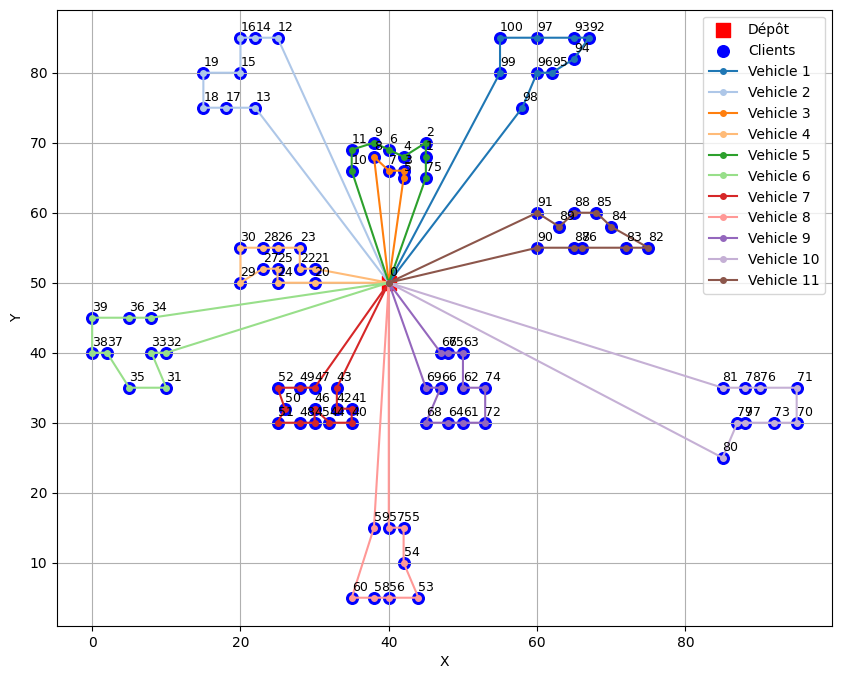

In [235]:
# importantes variables for tabu search
tabu_size = int(np.sqrt(instance.nb_client))
nb_iter = 400
nb_neighbors = 400
exploration_ratio = 1/10

clark = clark_and_wright(instance)
distance_clark = total_travel_distance(clark, instance)
tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)

distance_best = total_travel_distance(instance_best_solution, instance)
distance_tabu = total_travel_distance(tabu_solution, instance)

print(f"Upper bound: {distance_best}")
print(f"Tabu best: {distance_tabu}")

gap = (distance_tabu - distance_best) / distance_best * 100
print(f"Gap: {gap:.2f}%")
show_routes(tabu_solution, data_set)



Lancement de 16 recherches tabu en parallèle avec joblib...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   29.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   29.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished



Upper bound: 828.94
Tabu best (multi-process): 828.94
Gap: 0.00%


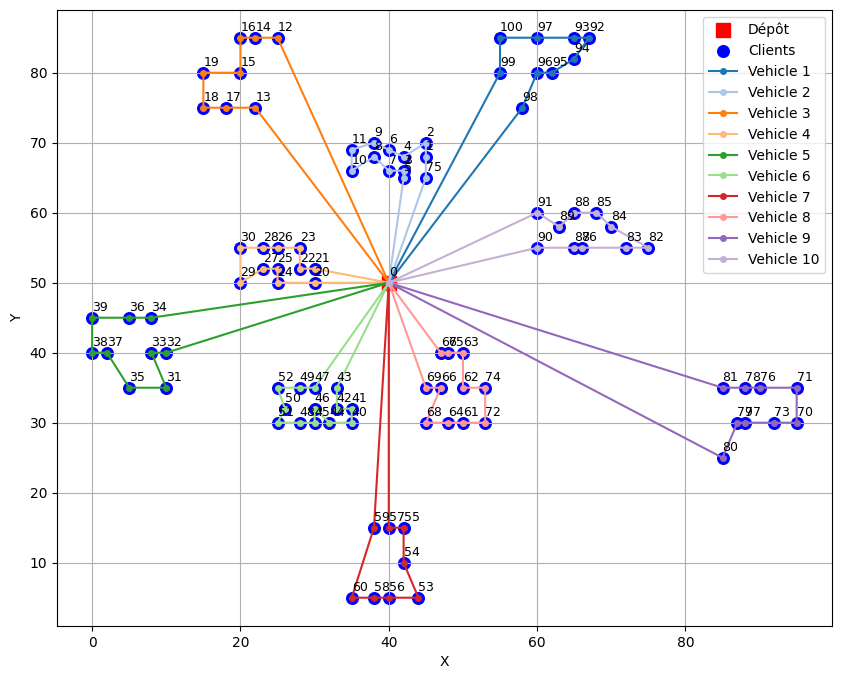

In [236]:
def run_single_tabu(seed):
    """Fonction qui sera exécutée en parallèle"""
    np.random.seed(seed)
    
    clark = clark_and_wright(instance)
    tabu_size = int(np.sqrt(instance.nb_client))
    nb_iter = 400
    nb_neighbors = 400
    exploration_ratio = 1/30
    
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, 
                                nb_neighbors, exploration_ratio)
    distance_tabu = total_travel_distance(tabu_solution, instance)
    
    print(f"Seed {seed} - Distance: {distance_tabu:.2f}")
    
    return tabu_solution, distance_tabu

n_runs = int(psutil.cpu_count(logical=True))

print(f"Lancement de {n_runs} recherches tabu en parallèle avec joblib...")

results = Parallel(n_jobs=-1, verbose=5, backend='loky')(
    delayed(run_single_tabu)(i) for i in range(n_runs)
)

best_solution = None
best_distance = float('inf')

for sol, dist in results:
    if dist < best_distance:
        best_distance = dist
        best_solution = copy.deepcopy(sol)

distance_best = total_travel_distance(instance_best_solution, instance)
gap = (best_distance - distance_best) / distance_best * 100

print(f"\n{'='*50}")
print(f"Upper bound: {distance_best:.2f}")
print(f"Tabu best (multi-process): {best_distance:.2f}")
print(f"Gap: {gap:.2f}%")
print(f"{'='*50}")
show_routes(best_solution, data_set)

# Test


Lancement de 590 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  

nb_neighbors=10: Gap=33.95% ± 3.44%, Time=1.09s
nb_neighbors=20: Gap=31.71% ± 3.45%, Time=2.18s
nb_neighbors=30: Gap=26.55% ± 5.29%, Time=3.71s
nb_neighbors=40: Gap=22.74% ± 2.92%, Time=5.67s
nb_neighbors=50: Gap=20.49% ± 3.90%, Time=7.03s
nb_neighbors=60: Gap=16.89% ± 3.06%, Time=7.94s
nb_neighbors=70: Gap=15.31% ± 4.35%, Time=17.05s
nb_neighbors=80: Gap=14.73% ± 4.93%, Time=19.61s
nb_neighbors=90: Gap=11.97% ± 4.47%, Time=20.16s
nb_neighbors=100: Gap=10.59% ± 2.04%, Time=18.07s
nb_neighbors=110: Gap=11.11% ± 3.59%, Time=17.06s
nb_neighbors=120: Gap=10.61% ± 3.39%, Time=20.64s
nb_neighbors=130: Gap=7.13% ± 3.25%, Time=21.54s
nb_neighbors=140: Gap=9.07% ± 3.65%, Time=26.14s
nb_neighbors=150: Gap=7.02% ± 3.03%, Time=33.07s
nb_neighbors=160: Gap=6.48% ± 3.43%, Time=30.84s
nb_neighbors=170: Gap=7.61% ± 2.08%, Time=31.43s
nb_neighbors=180: Gap=3.77% ± 3.36%, Time=36.34s
nb_neighbors=190: Gap=6.57% ± 3.64%, Time=34.66s
nb_neighbors=200: Gap=3.68% ± 3.02%, Time=54.41s
nb_neighbors=210: Gap=6

[Parallel(n_jobs=-1)]: Done 590 out of 590 | elapsed: 39.1min finished


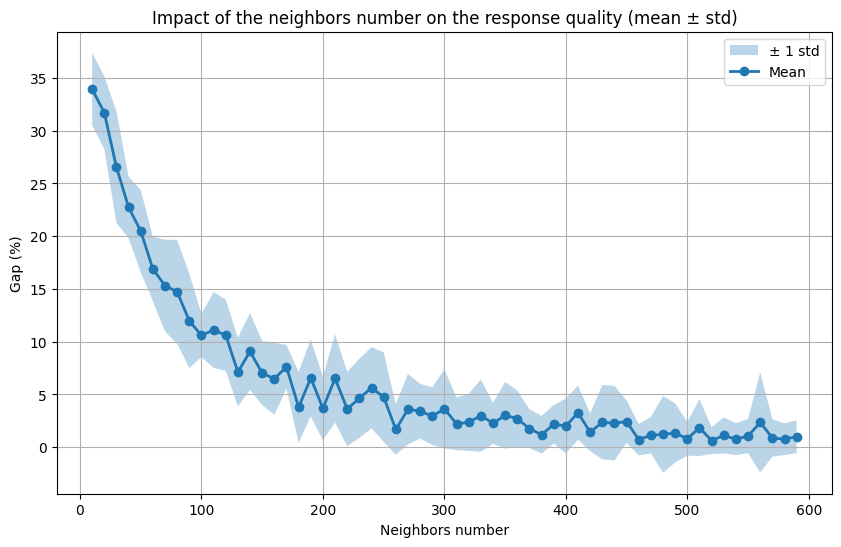

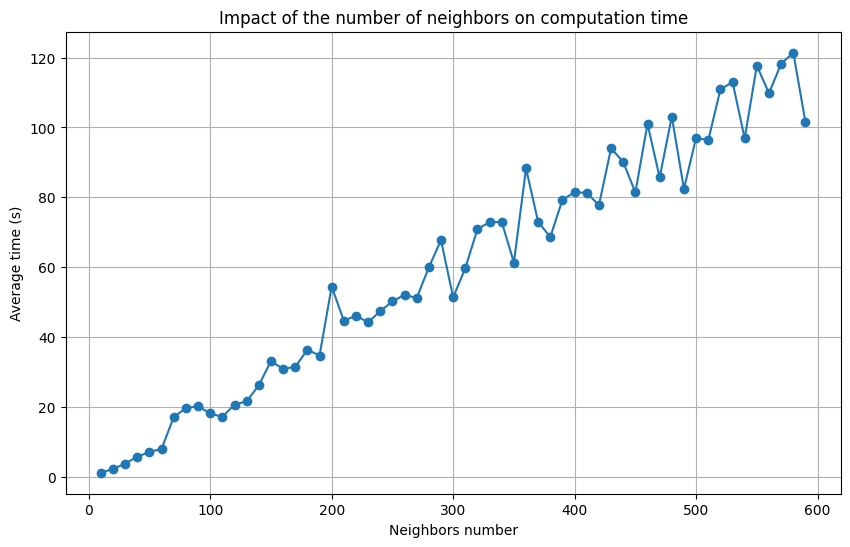

In [225]:
def run_neighbors_test(params):
    """Fonction pour tester un nb_neighbors avec un seed donné"""
    nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_neighbors_max = 600
step = 10
nb_iter = 200
nb_runs = 10
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_neighbors_values = np.arange(step, nb_neighbors_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_neighbors in nb_neighbors_values:
    for seed in range(nb_runs):
        all_params.append((nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_neighbors_test)(params) for params in all_params
)

# Regrouper les résultats par nb_neighbors
gap_means = []
gap_stds = []
time_means = []

for i, nb_neighbors in enumerate(nb_neighbors_values):
    # Extraire les résultats pour ce nb_neighbors
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_neighbors={nb_neighbors}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_neighbors_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_neighbors_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Neighbors number')
plt.ylabel('Gap (%)')
plt.title('Impact of the neighbors number on the response quality (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nb_neighbors_values, time_means, marker='o')
plt.xlabel('Neighbors number')
plt.ylabel('Average time (s)')
plt.title('Impact of the number of neighbors on computation time')
plt.grid(True)
plt.show()


Lancement de 590 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  

nb_iter=10: Gap=10.16% ± 3.63%, Time=3.02s
nb_iter=20: Gap=9.57% ± 4.39%, Time=4.68s
nb_iter=30: Gap=8.99% ± 4.25%, Time=6.27s
nb_iter=40: Gap=7.81% ± 4.52%, Time=9.14s
nb_iter=50: Gap=7.75% ± 4.46%, Time=11.57s
nb_iter=60: Gap=7.35% ± 3.90%, Time=14.38s
nb_iter=70: Gap=7.35% ± 3.90%, Time=16.58s
nb_iter=80: Gap=7.35% ± 3.90%, Time=20.54s
nb_iter=90: Gap=7.35% ± 3.90%, Time=22.58s
nb_iter=100: Gap=7.22% ± 4.05%, Time=26.36s
nb_iter=110: Gap=7.22% ± 4.05%, Time=29.00s
nb_iter=120: Gap=7.22% ± 4.05%, Time=362.02s
nb_iter=130: Gap=6.40% ± 4.56%, Time=2781.71s
nb_iter=140: Gap=5.20% ± 4.51%, Time=847.67s
nb_iter=150: Gap=5.20% ± 4.51%, Time=35.24s
nb_iter=160: Gap=4.76% ± 4.30%, Time=36.01s
nb_iter=170: Gap=4.04% ± 3.67%, Time=43.40s
nb_iter=180: Gap=4.04% ± 3.67%, Time=43.39s
nb_iter=190: Gap=3.68% ± 3.02%, Time=48.31s
nb_iter=200: Gap=3.68% ± 3.02%, Time=47.16s
nb_iter=210: Gap=3.68% ± 3.02%, Time=47.97s
nb_iter=220: Gap=3.68% ± 3.02%, Time=50.44s
nb_iter=230: Gap=3.68% ± 3.02%, Time=52.

[Parallel(n_jobs=-1)]: Done 590 out of 590 | elapsed: 89.5min finished


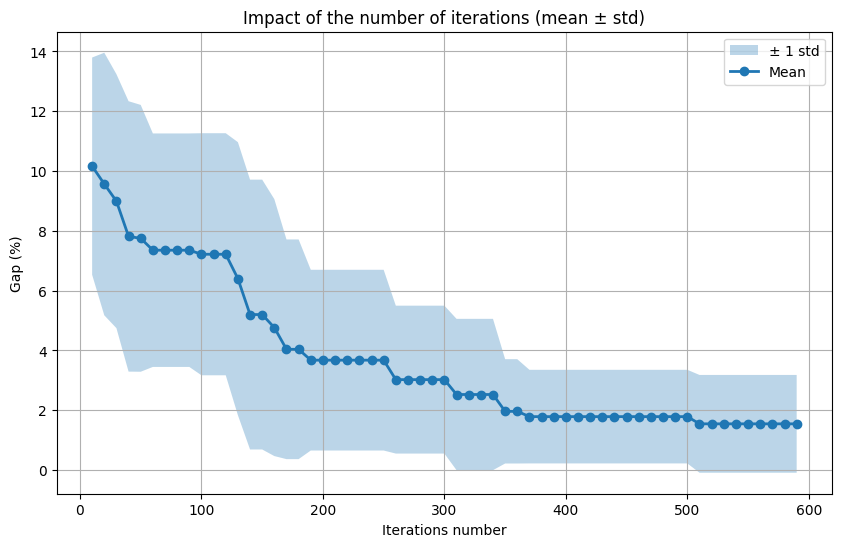

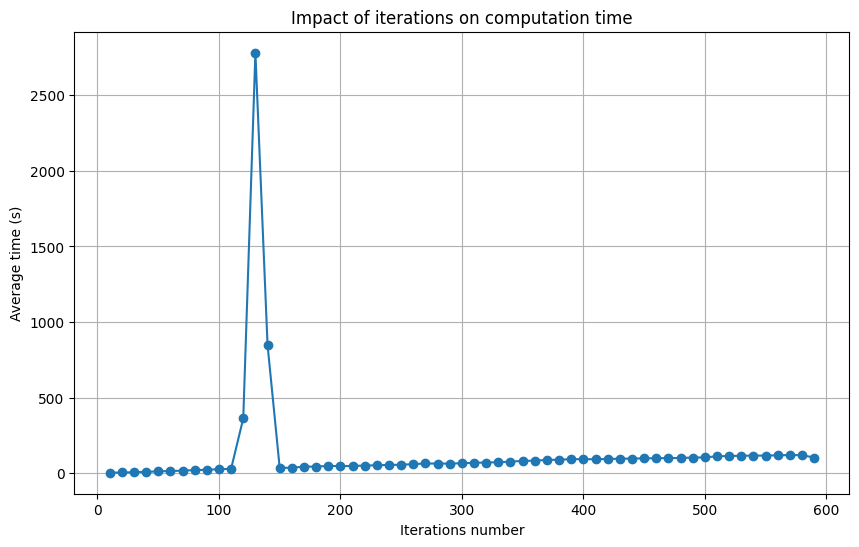

In [224]:
def run_iter_test(params):
    """Fonction pour tester un nb_iter avec un seed donné"""
    nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_iter_max = 600
step = 10
nb_neighbors = 200
nb_runs = 10
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_iter_values = np.arange(step, nb_iter_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_iter in nb_iter_values:
    for seed in range(nb_runs):
        all_params.append((nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_iter_test)(params) for params in all_params
)

# Regrouper les résultats par nb_iter
gap_means = []
gap_stds = []
time_means = []

for i, nb_iter in enumerate(nb_iter_values):
    # Extraire les résultats pour ce nb_iter
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_iter={nb_iter}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_iter_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_iter_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Iterations number')
plt.ylabel('Gap (%)')
plt.title('Impact of the number of iterations (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nb_iter_values, time_means, marker='o')
plt.xlabel('Iterations number')
plt.ylabel('Average time (s)')
plt.title('Impact of iterations on computation time')
plt.grid(True)
plt.show()


Lancement de 225 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  

tabu_size=10: Gap=2.93% ± 3.01%, Time=70.16s
tabu_size=12: Gap=3.20% ± 3.01%, Time=68.08s
tabu_size=14: Gap=4.53% ± 3.25%, Time=58.53s
tabu_size=16: Gap=3.86% ± 2.15%, Time=56.92s
tabu_size=18: Gap=4.58% ± 2.23%, Time=53.61s
tabu_size=20: Gap=3.99% ± 1.51%, Time=48.79s
tabu_size=22: Gap=4.43% ± 2.25%, Time=44.39s
tabu_size=24: Gap=4.43% ± 2.25%, Time=47.20s
tabu_size=26: Gap=5.13% ± 3.57%, Time=41.52s
tabu_size=28: Gap=5.63% ± 3.33%, Time=43.21s
tabu_size=30: Gap=6.98% ± 4.04%, Time=35.55s
tabu_size=32: Gap=5.41% ± 3.40%, Time=38.41s
tabu_size=34: Gap=4.22% ± 1.25%, Time=39.98s
tabu_size=36: Gap=5.10% ± 1.97%, Time=54.56s
tabu_size=38: Gap=6.55% ± 4.60%, Time=37.92s
tabu_size=40: Gap=6.55% ± 4.60%, Time=38.11s
tabu_size=42: Gap=6.55% ± 4.60%, Time=38.65s
tabu_size=44: Gap=6.91% ± 4.33%, Time=45.54s
tabu_size=46: Gap=6.00% ± 2.57%, Time=52.93s
tabu_size=48: Gap=6.00% ± 2.57%, Time=51.99s
tabu_size=50: Gap=6.00% ± 2.57%, Time=52.31s
tabu_size=52: Gap=6.00% ± 2.57%, Time=53.52s
tabu_size=

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 11.5min finished


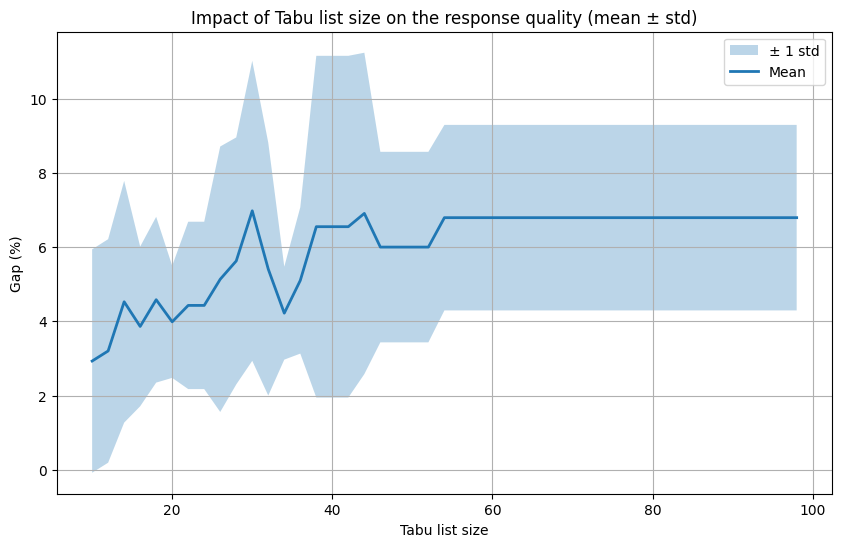

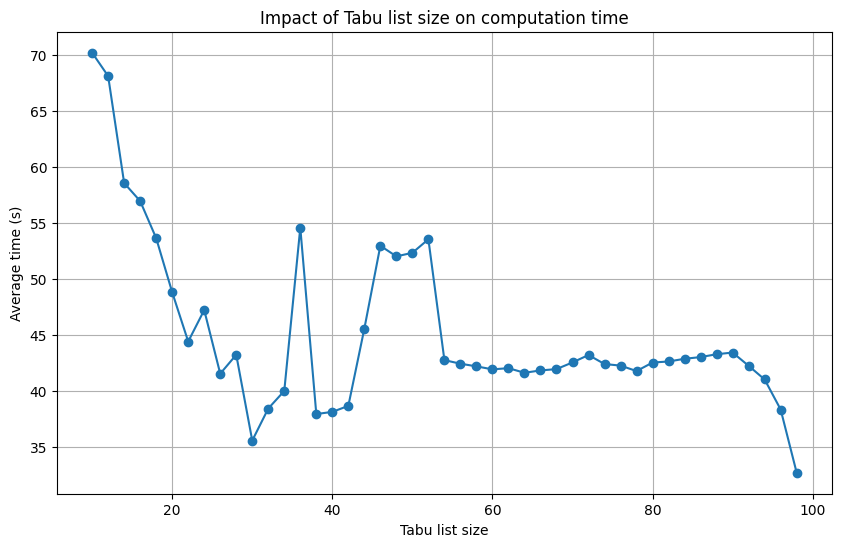

In [232]:
def run_tabu_size_test(params):
    """Fonction pour tester un tabu_size avec un seed donné"""
    tabu_size, seed, nb_iter, nb_neighbors, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, int(tabu_size), nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
tabu_size_max = instance.nb_client
step = 2
nb_iter = 200
nb_neighbors = 200
nb_runs = 5
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
tabu_size_values = np.arange(np.sqrt(instance.nb_client), tabu_size_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for tabu_size in tabu_size_values:
    for seed in range(nb_runs):
        all_params.append((tabu_size, seed, nb_iter, nb_neighbors, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_tabu_size_test)(params) for params in all_params
)

# Regrouper les résultats par tabu_size
gap_means = []
gap_stds = []
time_means = []

for i, tabu_size in enumerate(tabu_size_values):
    # Extraire les résultats pour ce tabu_size
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"tabu_size={int(tabu_size)}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(tabu_size_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(tabu_size_values, gap_means, linewidth=2, markersize=6, label='Mean')

plt.xlabel('Tabu list size')
plt.ylabel('Gap (%)')
plt.title('Impact of Tabu list size on the response quality (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(tabu_size_values, time_means, marker='o')
plt.xlabel('Tabu list size')
plt.ylabel('Average time (s)')
plt.title('Impact of Tabu list size on computation time')
plt.grid(True)
plt.show()


Lancement de 210 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  

exploration_ratio=0.00 (0%): Gap=6.23% ± 3.34%, Time=30.59s
exploration_ratio=0.05 (5%): Gap=5.48% ± 2.20%, Time=40.75s
exploration_ratio=0.10 (10%): Gap=3.68% ± 3.02%, Time=53.23s
exploration_ratio=0.15 (15%): Gap=3.85% ± 3.19%, Time=40.14s
exploration_ratio=0.20 (20%): Gap=2.96% ± 2.04%, Time=46.10s
exploration_ratio=0.25 (25%): Gap=3.51% ± 4.06%, Time=39.85s
exploration_ratio=0.30 (30%): Gap=5.53% ± 2.48%, Time=46.16s
exploration_ratio=0.35 (35%): Gap=3.70% ± 2.99%, Time=55.11s
exploration_ratio=0.40 (40%): Gap=4.30% ± 3.78%, Time=43.22s
exploration_ratio=0.45 (45%): Gap=4.39% ± 3.84%, Time=68.23s
exploration_ratio=0.50 (50%): Gap=4.16% ± 4.72%, Time=47.62s
exploration_ratio=0.55 (55%): Gap=5.05% ± 4.13%, Time=55.11s
exploration_ratio=0.60 (60%): Gap=4.07% ± 3.16%, Time=49.40s
exploration_ratio=0.65 (65%): Gap=3.60% ± 3.45%, Time=56.73s
exploration_ratio=0.70 (70%): Gap=3.26% ± 3.83%, Time=51.20s
exploration_ratio=0.75 (75%): Gap=4.34% ± 3.94%, Time=56.00s
exploration_ratio=0.80 (80

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 11.7min finished


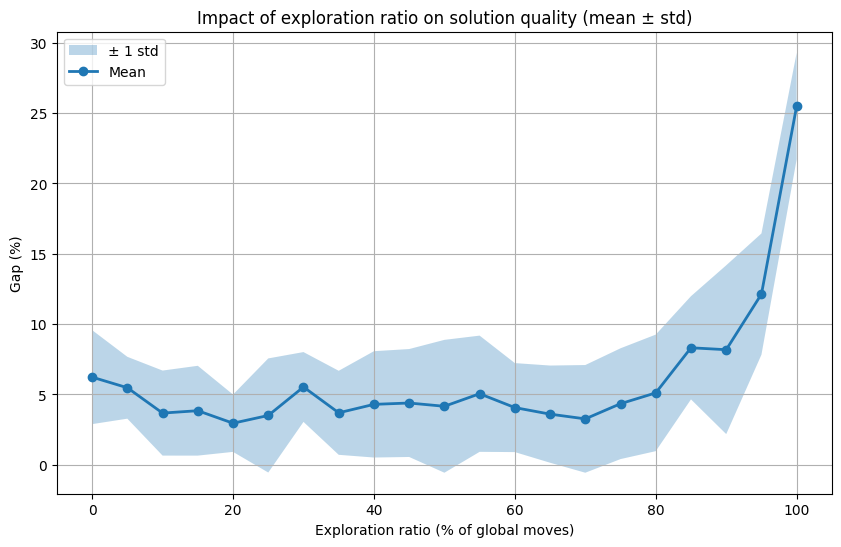

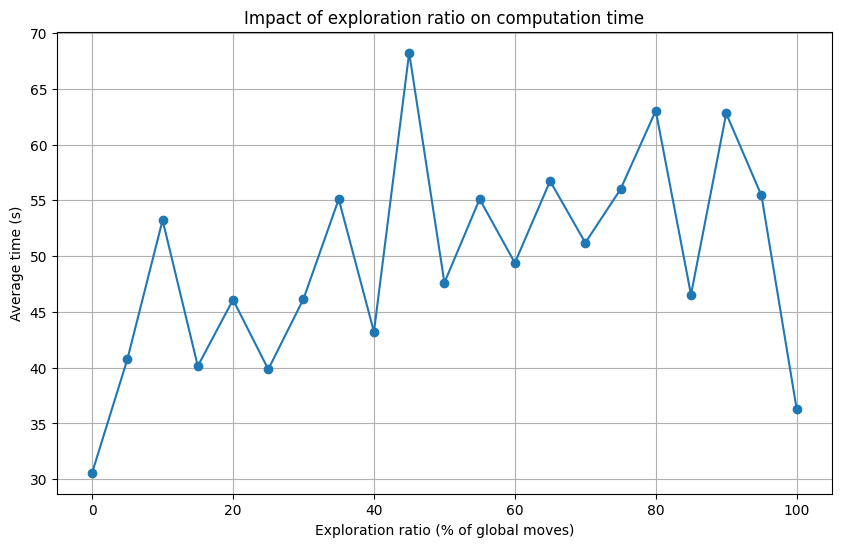

In [234]:
def run_exploration_ratio_test(params):
    """Fonction pour tester un exploration_ratio avec un seed donné"""
    exploration_ratio, seed, nb_iter, nb_neighbors, tabu_size = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
exploration_ratio_min = 0.0  # 0% de recherche globale (que du local)
exploration_ratio_max = 1.0  # 100% de recherche globale
step = 0.05  # 5% d'incrémentation
nb_iter = 200
nb_neighbors = 200
nb_runs = 10
tabu_size = int(np.sqrt(instance.nb_client))

distance_best = total_travel_distance(instance_best_solution, instance)
exploration_ratio_values = np.arange(exploration_ratio_min, exploration_ratio_max + step, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for exploration_ratio in exploration_ratio_values:
    for seed in range(nb_runs):
        all_params.append((exploration_ratio, seed, nb_iter, nb_neighbors, tabu_size))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_exploration_ratio_test)(params) for params in all_params
)

# Regrouper les résultats par exploration_ratio
gap_means = []
gap_stds = []
time_means = []

for i, exploration_ratio in enumerate(exploration_ratio_values):
    # Extraire les résultats pour ce exploration_ratio
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"exploration_ratio={exploration_ratio:.2f} ({exploration_ratio*100:.0f}%): Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Convertir en pourcentage pour l'axe X
exploration_ratio_percent = exploration_ratio_values * 100

# Zone d'erreur (mean ± std)
plt.fill_between(exploration_ratio_percent, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(exploration_ratio_percent, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Exploration ratio (% of global moves)')
plt.ylabel('Gap (%)')
plt.title('Impact of exploration ratio on solution quality (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(exploration_ratio_percent, time_means, marker='o')
plt.xlabel('Exploration ratio (% of global moves)')
plt.ylabel('Average time (s)')
plt.title('Impact of exploration ratio on computation time')
plt.grid(True)
plt.show()


# Test (with 20 runs)

Lancement de 38 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  27 out of  38 | elapsed:  4.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:  4.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  35 out of  38 | elapsed:  5.9min remaining:   30.1s


nb_neighbors=25: Gap=29.97% ± 1.76%, Time=4.65s
nb_neighbors=50: Gap=16.35% ± 4.14%, Time=9.93s
nb_neighbors=75: Gap=17.33% ± 0.04%, Time=13.87s
nb_neighbors=100: Gap=9.19% ± 0.76%, Time=20.88s
nb_neighbors=125: Gap=9.05% ± 2.97%, Time=44.63s
nb_neighbors=150: Gap=10.30% ± 1.82%, Time=42.96s
nb_neighbors=175: Gap=2.70% ± 2.70%, Time=62.60s
nb_neighbors=200: Gap=1.21% ± 1.21%, Time=70.46s
nb_neighbors=225: Gap=10.56% ± 1.07%, Time=48.20s
nb_neighbors=250: Gap=4.60% ± 0.38%, Time=69.30s
nb_neighbors=275: Gap=10.05% ± 5.85%, Time=61.32s
nb_neighbors=300: Gap=0.00% ± 0.00%, Time=103.09s
nb_neighbors=325: Gap=0.00% ± 0.00%, Time=171.35s
nb_neighbors=350: Gap=2.29% ± 2.29%, Time=87.96s
nb_neighbors=375: Gap=0.00% ± 0.00%, Time=100.53s
nb_neighbors=400: Gap=1.89% ± 1.89%, Time=84.91s
nb_neighbors=425: Gap=0.00% ± 0.00%, Time=122.89s
nb_neighbors=450: Gap=4.38% ± 0.60%, Time=100.07s
nb_neighbors=475: Gap=0.00% ± 0.00%, Time=78.03s


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  6.3min finished


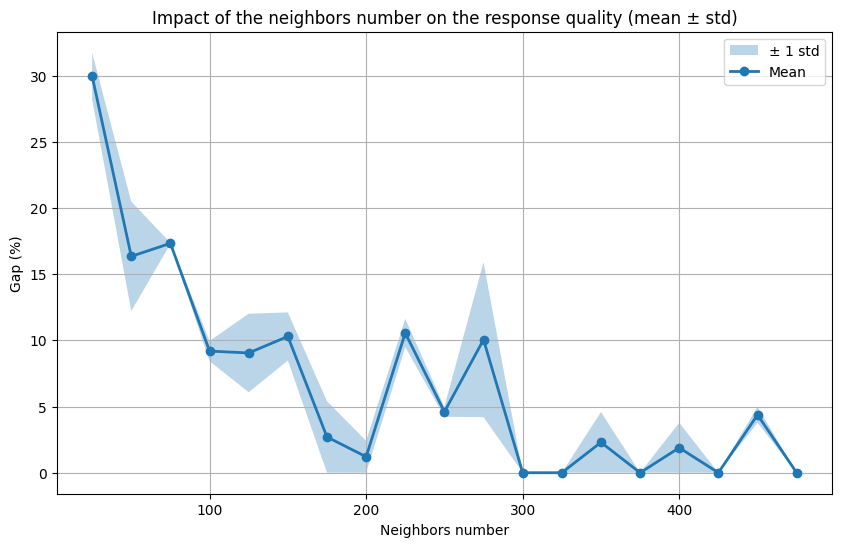

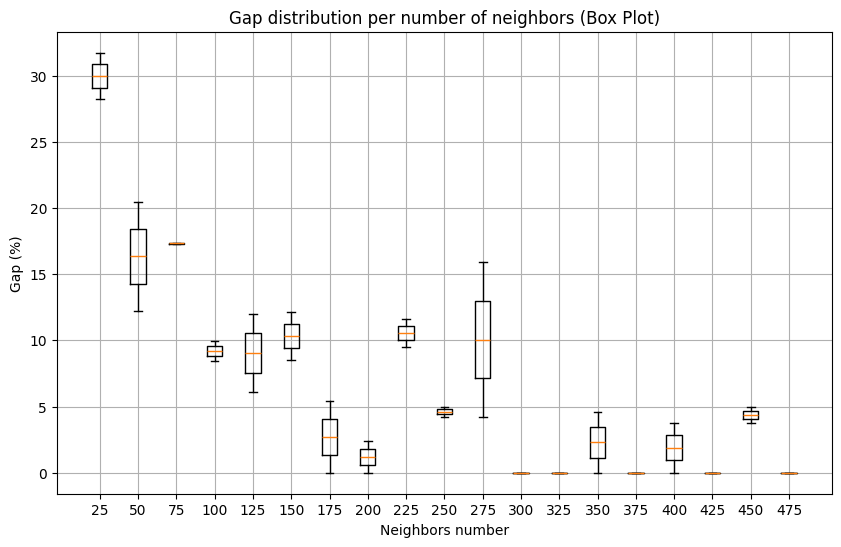

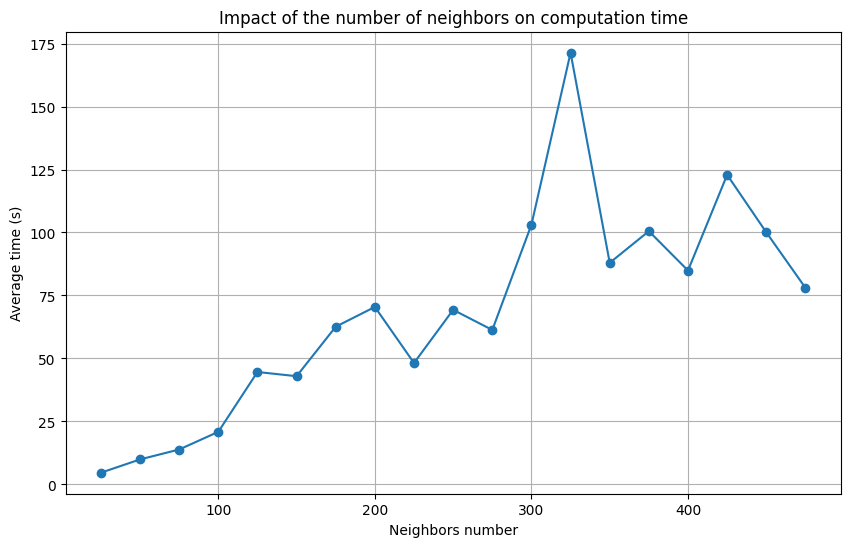

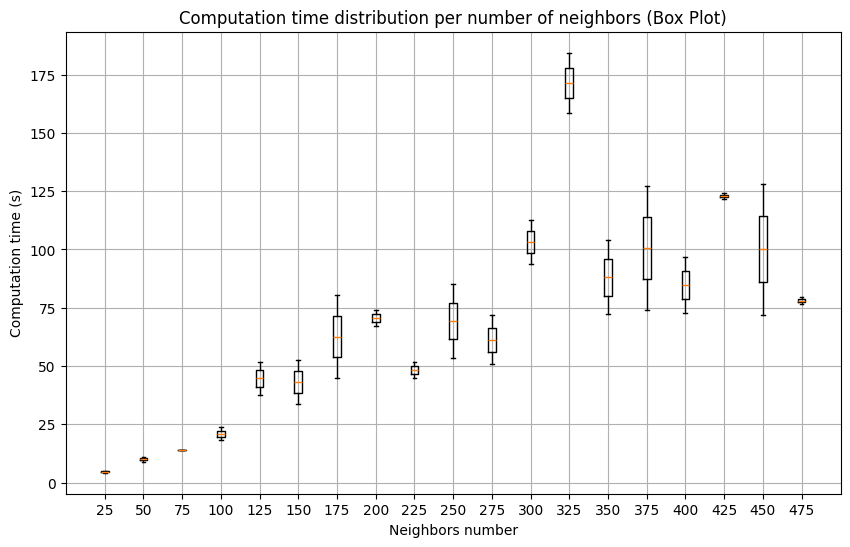

In [36]:
def run_neighbors_test(params):
    """Fonction pour tester un nb_neighbors avec un seed donné"""
    nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_neighbors_max = 500
step = 25
nb_iter = 200
nb_runs = 2
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_neighbors_values = np.arange(step, nb_neighbors_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_neighbors in nb_neighbors_values:
    for seed in range(nb_runs):
        all_params.append((nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_neighbors_test)(params) for params in all_params
)

# Regrouper les résultats par nb_neighbors
gap_means = []
gap_stds = []
time_means = []

for i, nb_neighbors in enumerate(nb_neighbors_values):
    # Extraire les résultats pour ce nb_neighbors
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_neighbors={nb_neighbors}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_neighbors_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_neighbors_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Neighbors number')
plt.ylabel('Gap (%)')
plt.title('Impact of the neighbors number on the response quality (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------
plt.figure(figsize=(10, 6))

# Collect gap data grouped by nb_neighbors
gap_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_neighbors_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    gap_data_per_neighbor.append(gaps)

plt.boxplot(gap_data_per_neighbor, positions=nb_neighbors_values, widths=10)
plt.xlabel('Neighbors number')
plt.ylabel('Gap (%)')
plt.title('Gap distribution per number of neighbors (Box Plot)')
plt.grid(True)
plt.show()


# ---------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(nb_neighbors_values, time_means, marker='o')
plt.xlabel('Neighbors number')
plt.ylabel('Average time (s)')
plt.title('Impact of the number of neighbors on computation time')
plt.grid(True)
plt.show()

# ---------------------------------------------------
plt.figure(figsize=(10, 6))

# Collect time data grouped by nb_neighbors
time_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_neighbors_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    times = [results[j][1] for j in range(start_idx, end_idx)]
    time_data_per_neighbor.append(times)

plt.boxplot(time_data_per_neighbor, positions=nb_neighbors_values, widths=5)
plt.xlabel('Neighbors number')
plt.ylabel('Computation time (s)')
plt.title('Computation time distribution per number of neighbors (Box Plot)')
plt.grid(True)
plt.show()

Lancement de 38 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  27 out of  38 | elapsed:  4.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:  5.3min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  35 out of  38 | elapsed:  5.9min remaining:   30.4s


nb_iter=25: Gap=5.97% ± 2.19%, Time=10.23s
nb_iter=50: Gap=5.97% ± 2.19%, Time=13.91s
nb_iter=75: Gap=5.97% ± 2.19%, Time=21.92s
nb_iter=100: Gap=5.29% ± 2.87%, Time=37.52s
nb_iter=125: Gap=5.29% ± 2.87%, Time=43.34s
nb_iter=150: Gap=1.21% ± 1.21%, Time=64.74s
nb_iter=175: Gap=1.21% ± 1.21%, Time=70.32s
nb_iter=200: Gap=1.21% ± 1.21%, Time=79.39s
nb_iter=225: Gap=1.21% ± 1.21%, Time=76.04s
nb_iter=250: Gap=1.21% ± 1.21%, Time=73.67s
nb_iter=275: Gap=1.21% ± 1.21%, Time=87.32s
nb_iter=300: Gap=1.21% ± 1.21%, Time=94.98s
nb_iter=325: Gap=1.21% ± 1.21%, Time=90.98s
nb_iter=350: Gap=1.21% ± 1.21%, Time=91.10s
nb_iter=375: Gap=1.21% ± 1.21%, Time=97.25s
nb_iter=400: Gap=1.21% ± 1.21%, Time=100.00s
nb_iter=425: Gap=1.21% ± 1.21%, Time=102.86s
nb_iter=450: Gap=1.21% ± 1.21%, Time=98.60s
nb_iter=475: Gap=1.21% ± 1.21%, Time=77.86s


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  6.2min finished


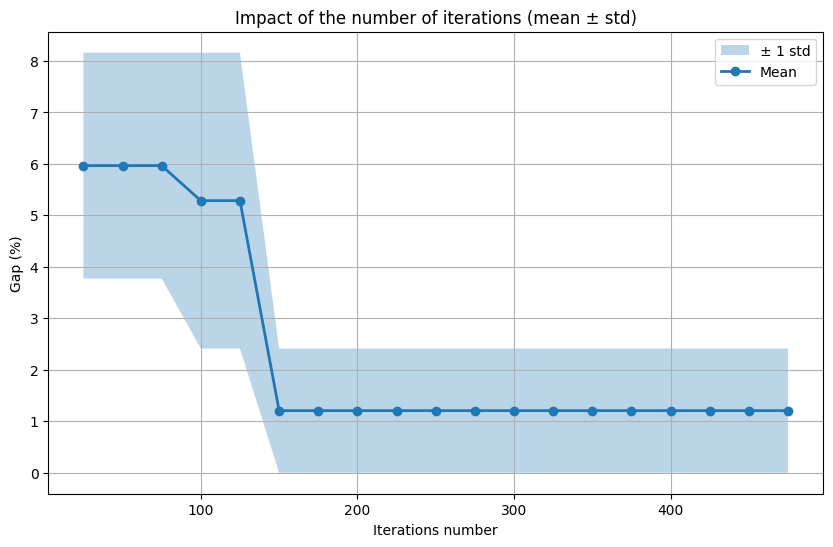

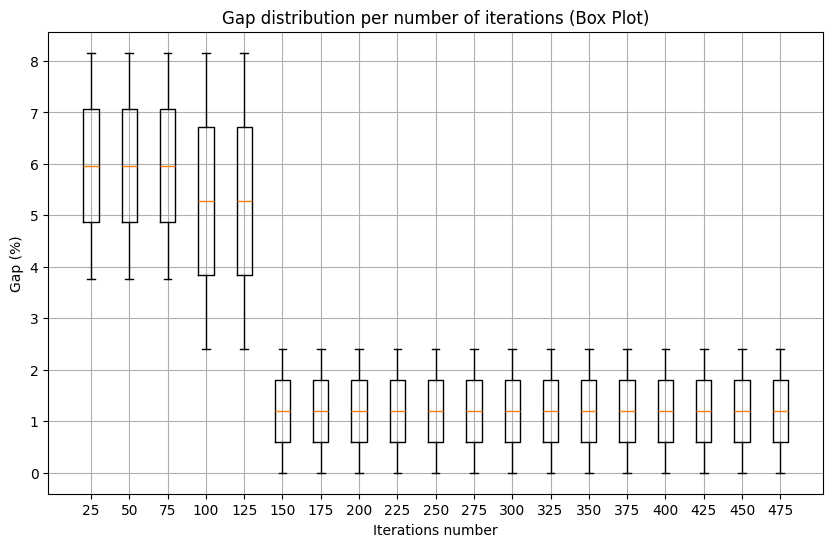

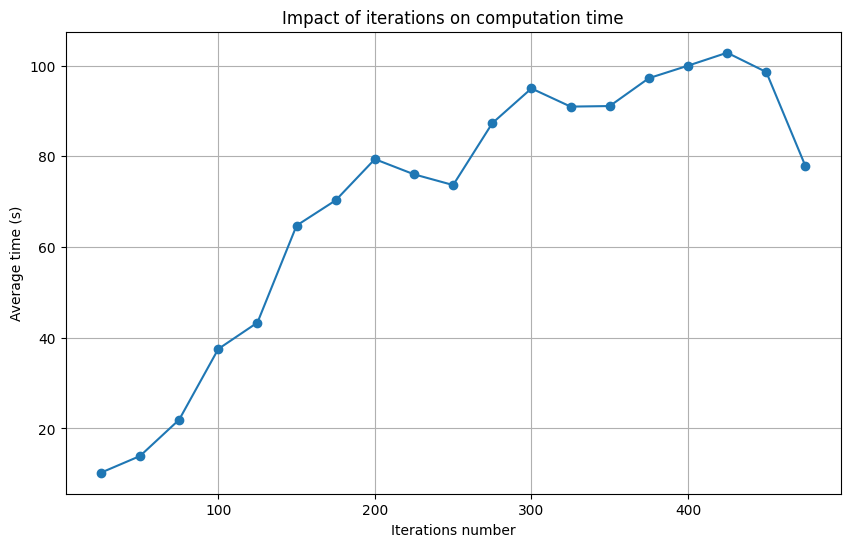

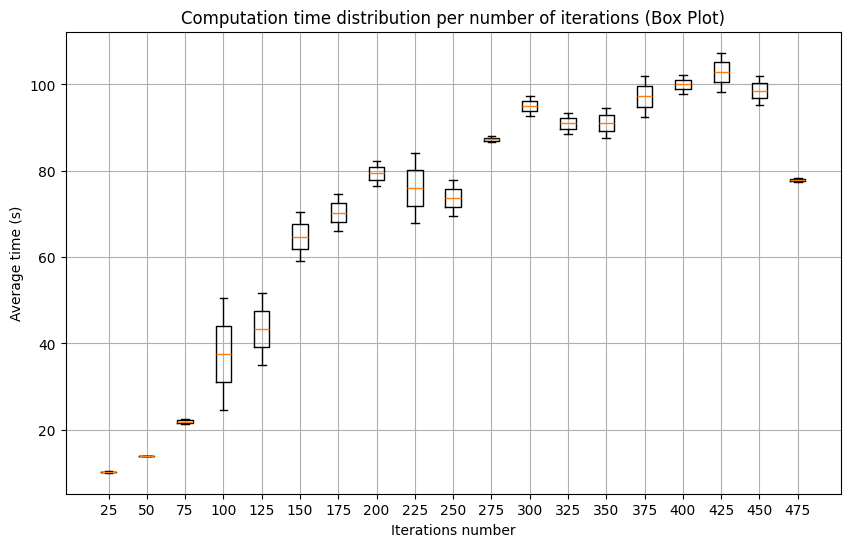

In [40]:
def run_iter_test(params):
    """Fonction pour tester un nb_iter avec un seed donné"""
    nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_iter_max = 500
step = 25
nb_neighbors = 200
nb_runs = 2
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_iter_values = np.arange(step, nb_iter_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_iter in nb_iter_values:
    for seed in range(nb_runs):
        all_params.append((nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_iter_test)(params) for params in all_params
)

# Regrouper les résultats par nb_iter
gap_means = []
gap_stds = []
time_means = []

for i, nb_iter in enumerate(nb_iter_values):
    # Extraire les résultats pour ce nb_iter
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_iter={nb_iter}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_iter_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_iter_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Iterations number')
plt.ylabel('Gap (%)')
plt.title('Impact of the number of iterations (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
gap_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_iter_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    gap_data_per_neighbor.append(gaps)
plt.boxplot(gap_data_per_neighbor, positions=nb_iter_values, widths=10)
plt.xlabel('Iterations number')
plt.ylabel('Gap (%)')
plt.title('Gap distribution per number of iterations (Box Plot)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nb_iter_values, time_means, marker='o')
plt.xlabel('Iterations number')
plt.ylabel('Average time (s)')
plt.title('Impact of iterations on computation time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
time_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_iter_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    times = [results[j][1] for j in range(start_idx, end_idx)]
    time_data_per_neighbor.append(times)
plt.boxplot(time_data_per_neighbor, positions=nb_iter_values, widths=10)
plt.xlabel('Iterations number')
plt.ylabel('Average time (s)')
plt.title('Computation time distribution per number of iterations (Box Plot)')
plt.grid(True)
plt.show()


In [1]:
def run_neighbors_test(params):
    """Fonction pour tester un nb_neighbors avec un seed donné"""
    nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_neighbors_max = 600
step = 10
nb_iter = 200
nb_runs = 2
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_neighbors_values = np.arange(step, nb_neighbors_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_neighbors in nb_neighbors_values:
    for seed in range(nb_runs):
        all_params.append((nb_neighbors, seed, nb_iter, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_neighbors_test)(params) for params in all_params
)

# Regrouper les résultats par nb_neighbors
gap_means = []
gap_stds = []
time_means = []

for i, nb_neighbors in enumerate(nb_neighbors_values):
    # Extraire les résultats pour ce nb_neighbors
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_neighbors={nb_neighbors}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_neighbors_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_neighbors_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Neighbors number')
plt.ylabel('Gap (%)')
plt.title('Impact of the neighbors number on the response quality (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
gap_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_neighbors_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    gap_data_per_neighbor.append(gaps)
plt.boxplot(gap_data_per_neighbor, positions=nb_neighbors_values, widths=10)
plt.xlabel('Neighbors number')
plt.ylabel('Gap (%)')
plt.title('Gap distribution per number of neighbors (Box Plot)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nb_neighbors_values, time_means, marker='o')
plt.xlabel('Neighbors number')
plt.ylabel('Average time (s)')
plt.title('Impact of the number of neighbors on computation time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
time_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_neighbors_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    times = [results[j][1] for j in range(start_idx, end_idx)]
    time_data_per_neighbor.append(times)
plt.boxplot(time_data_per_neighbor, positions=nb_neighbors_values, widths=10)
plt.xlabel('Neighbors number')
plt.ylabel('Computation time (s)')
plt.title('Computation time distribution per number of neighbors (Box Plot)')
plt.grid(True)
plt.show()


NameError: name 'np' is not defined

Lancement de 42 tests en parallèle...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  32 out of  42 | elapsed:  5.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  37 out of  42 | elapsed:  6.2min remaining:   50.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  6.7min finished


exploration_ratio=0.00 (0%): Gap=6.84% ± 1.87%, Time=44.01s
exploration_ratio=0.05 (5%): Gap=6.70% ± 1.29%, Time=44.29s
exploration_ratio=0.10 (10%): Gap=1.21% ± 1.21%, Time=76.08s
exploration_ratio=0.15 (15%): Gap=1.89% ± 1.89%, Time=75.37s
exploration_ratio=0.20 (20%): Gap=1.89% ± 1.89%, Time=59.41s
exploration_ratio=0.25 (25%): Gap=1.34% ± 1.34%, Time=64.27s
exploration_ratio=0.30 (30%): Gap=6.65% ± 2.44%, Time=65.18s
exploration_ratio=0.35 (35%): Gap=3.76% ± 1.35%, Time=95.54s
exploration_ratio=0.40 (40%): Gap=6.68% ± 1.38%, Time=46.89s
exploration_ratio=0.45 (45%): Gap=1.21% ± 1.21%, Time=87.64s
exploration_ratio=0.50 (50%): Gap=4.11% ± 4.11%, Time=80.78s
exploration_ratio=0.55 (55%): Gap=5.81% ± 5.81%, Time=78.50s
exploration_ratio=0.60 (60%): Gap=4.88% ± 4.88%, Time=61.69s
exploration_ratio=0.65 (65%): Gap=1.89% ± 1.89%, Time=117.28s
exploration_ratio=0.70 (70%): Gap=0.00% ± 0.00%, Time=68.00s
exploration_ratio=0.75 (75%): Gap=2.28% ± 2.28%, Time=119.24s
exploration_ratio=0.80 (

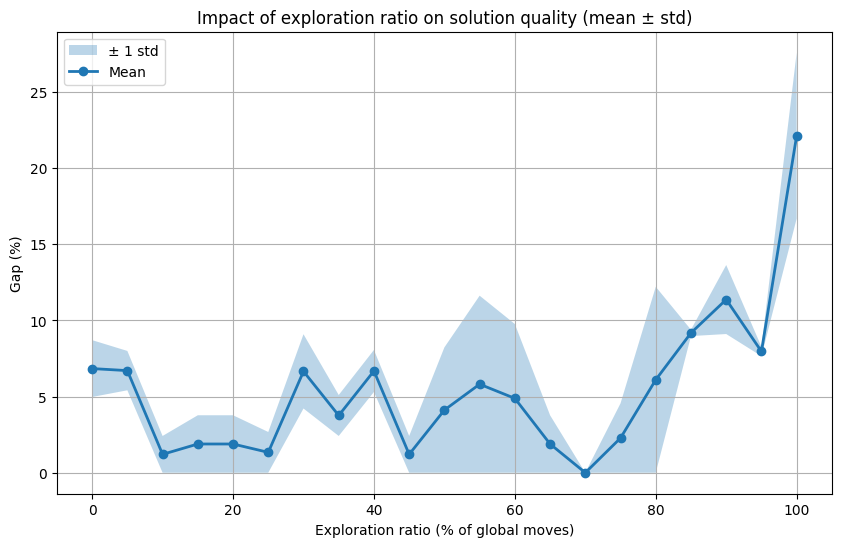

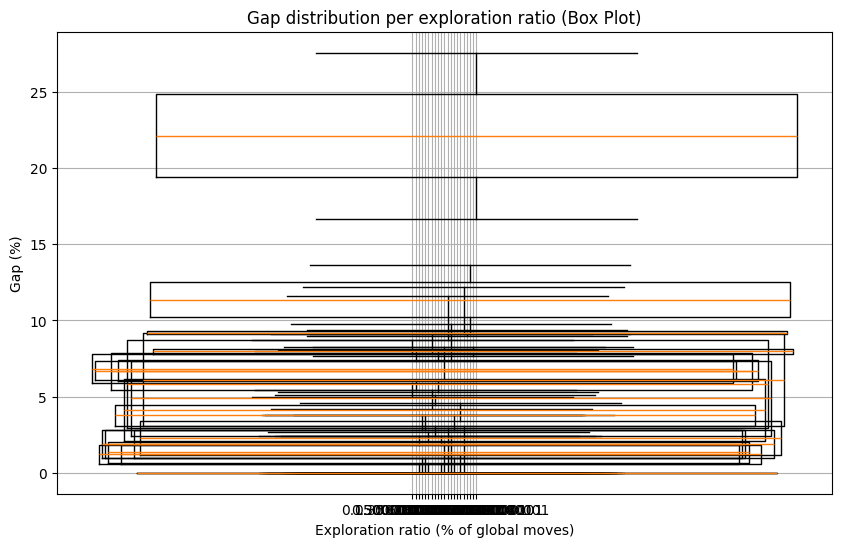

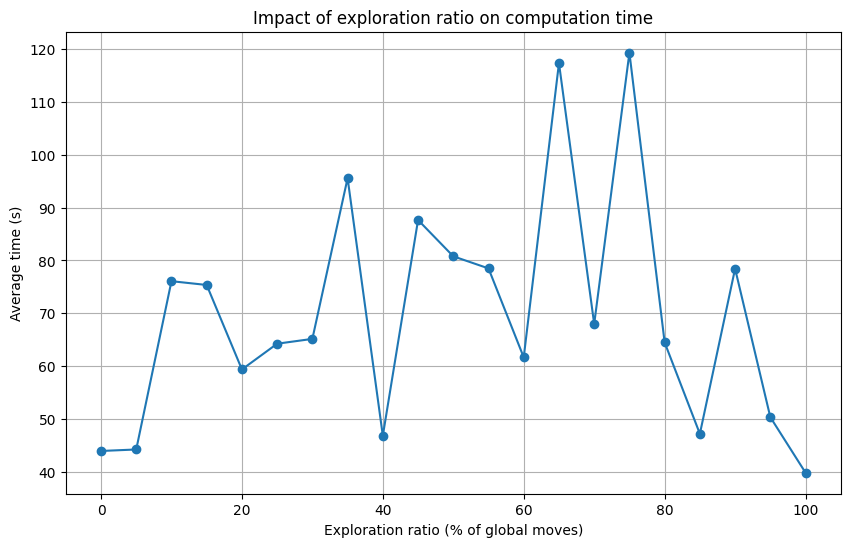

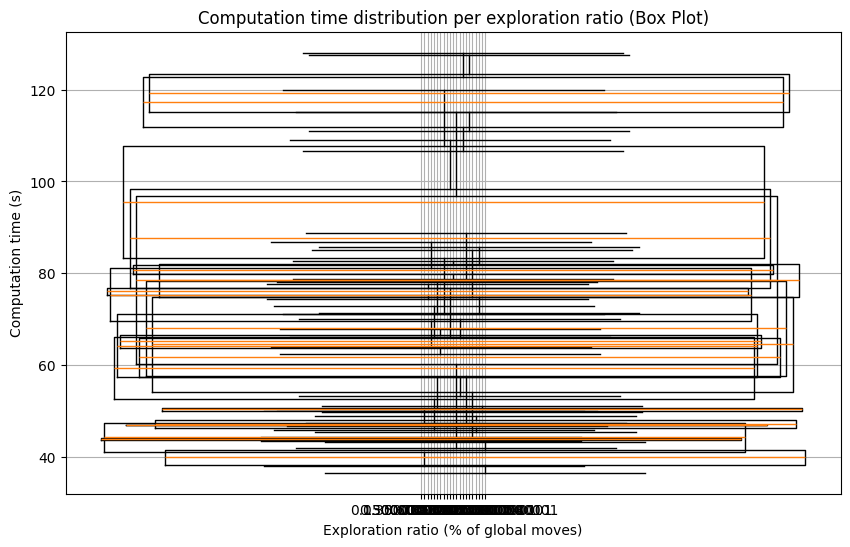

In [ ]:
def run_iter_test(params):
    """Fonction pour tester un nb_iter avec un seed donné"""
    nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio = params
    np.random.seed(seed)
    random.seed(seed)
    
    clark = clark_and_wright(instance)
    
    start = time.time()
    tabu_solution = tabu_search(instance, clark, tabu_size, nb_iter, nb_neighbors, exploration_ratio)
    end = time.time()
    
    distance_tabu = total_travel_distance(tabu_solution, instance)
    distance_best = total_travel_distance(instance_best_solution, instance)
    gap = (distance_tabu - distance_best) / distance_best * 100
    
    return gap, end - start

# Paramètres
nb_iter_max = 600
step = 10
nb_neighbors = 200
nb_runs = 10
tabu_size = int(np.sqrt(instance.nb_client))
exploration_ratio = 1/10

distance_best = total_travel_distance(instance_best_solution, instance)
nb_iter_values = np.arange(step, nb_iter_max, step)

# Préparer tous les paramètres pour le multiprocessing
all_params = []
for nb_iter in nb_iter_values:
    for seed in range(nb_runs):
        all_params.append((nb_iter, seed, nb_neighbors, tabu_size, exploration_ratio))

print(f"Lancement de {len(all_params)} tests en parallèle...")

# Exécution en parallèle
results = Parallel(n_jobs=-1, verbose=10, backend='loky')(
    delayed(run_iter_test)(params) for params in all_params
)

# Regrouper les résultats par nb_iter
gap_means = []
gap_stds = []
time_means = []

for i, nb_iter in enumerate(nb_iter_values):
    # Extraire les résultats pour ce nb_iter
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    times = [results[j][1] for j in range(start_idx, end_idx)]
    
    gap_means.append(np.mean(gaps))
    gap_stds.append(np.std(gaps))
    time_means.append(np.mean(times))
    
    print(f"nb_iter={nb_iter}: Gap={np.mean(gaps):.2f}% ± {np.std(gaps):.2f}%, Time={np.mean(times):.2f}s")

# Affichage des graphiques
plt.figure(figsize=(10, 6))

# Convertir en numpy arrays pour faciliter les calculs
gap_means_array = np.array(gap_means)
gap_stds_array = np.array(gap_stds)

# Zone d'erreur (mean ± std)
plt.fill_between(nb_iter_values, gap_means_array - gap_stds_array, gap_means_array + gap_stds_array, alpha=0.3, label='± 1 std')

# Courbe principale
plt.plot(nb_iter_values, gap_means, '-o', linewidth=2, markersize=6, label='Mean')

plt.xlabel('Iterations number')
plt.ylabel('Gap (%)')
plt.title('Impact of the number of iterations (mean ± std)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
gap_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_iter_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    gaps = [results[j][0] for j in range(start_idx, end_idx)]
    gap_data_per_neighbor.append(gaps)
plt.boxplot(gap_data_per_neighbor, positions=nb_iter_values, widths=10)
plt.xlabel('iterations number')
plt.ylabel('Gap (%)')
plt.title('Gap distribution per number of iterations (Box Plot)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nb_iter_values, time_means, marker='o')
plt.xlabel('Iterations number')
plt.ylabel('Average time (s)')
plt.title('Impact of iterations on computation time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
time_data_per_neighbor = []
for i, nb_neighbors in enumerate(nb_iter_values):
    start_idx = i * nb_runs
    end_idx = start_idx + nb_runs
    times = [results[j][1] for j in range(start_idx, end_idx)]
    time_data_per_neighbor.append(times)

plt.boxplot(time_data_per_neighbor, positions=nb_iter_values, widths=10)
plt.xlabel('iterations number')
plt.ylabel('Computation time (s)')
plt.title('Computation time distribution per number of iterations (Box Plot)')
plt.grid(True)
plt.show()
